In [1]:
from commonfunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
target_img_size = (256, 256)

In [3]:
cow_select=io.imread('images-to-be-tested/cow_with_selection.png')
garb_select=io.imread('images-to-be-tested/garbage_with_selection.png')

cow_orig=io.imread('images-to-be-tested/cow.jpg')
garb_orig=io.imread('images-to-be-tested/garbage.jpg')

In [4]:
# cow_resized_img=cv2.resize(cow_select,target_img_size)
cow_sel_resize=cv2.resize(cow_select,target_img_size)

# cow_sel_resized=rgba2rgb(cow_resized_img)
cow_sel_conversion=rgba2rgb(cow_sel_resize)

# cow_resized_orig=cv2.resize(cow_orig,target_img_size)
cow_resized_orig=cv2.resize(cow_orig,target_img_size)

#for colors only:
#normalized_garb_resized_img = (garb_resized_orig - np.min(garb_resized_orig)) / (np.max(garb_resized_orig) - np.min(garb_resized_orig))


# print(normalized_garb_resized_img)
# print(garb_sel_conversion)

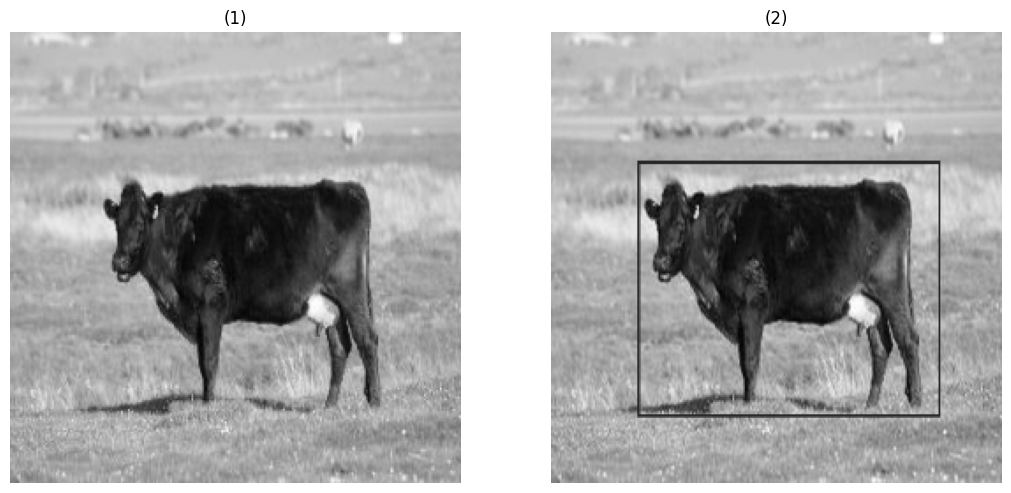

In [5]:
gray_orig_cow=rgb2gray(cow_resized_orig)
gray_sel_cow=rgb2gray(cow_sel_conversion)
show_images(images=[gray_orig_cow, gray_sel_cow])

Step 1: Finding difference between both image

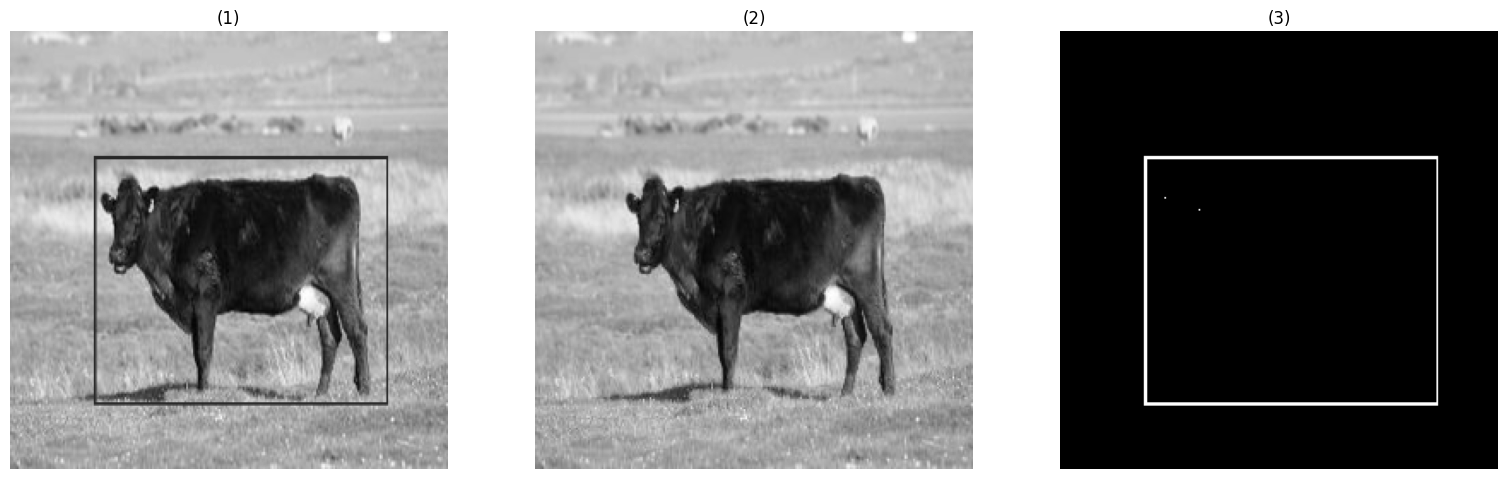

In [6]:
diff_cow = np.abs(gray_sel_cow - gray_orig_cow)

# Brightness Adjustment
result_cow=np.zeros((gray_sel_cow.shape))
result_cow[diff_cow>0.1]=1
#result_image_garb = np.where(difference_image_garb > 0.09, 1, garb_resized_orig)

show_images(images=[gray_sel_cow,gray_orig_cow,result_cow])

Step 2: Morphology:

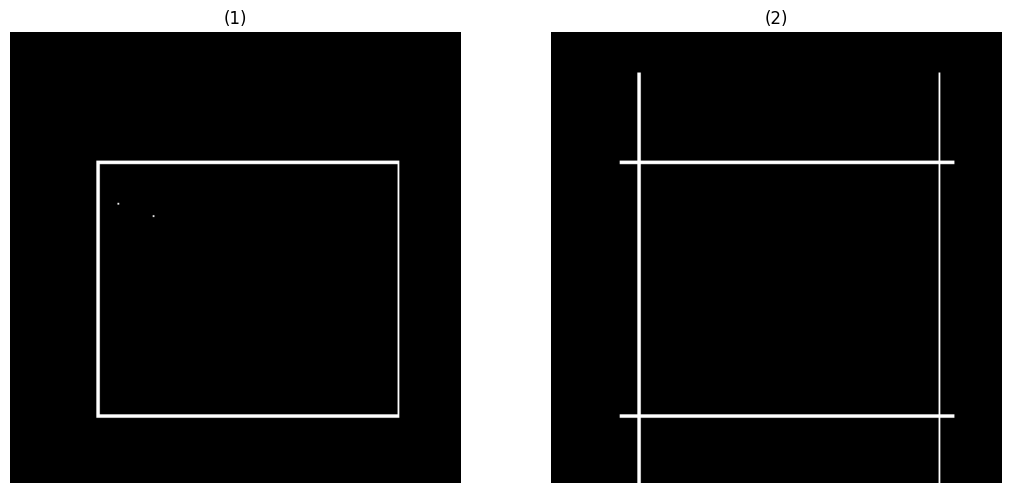

In [7]:
# we will use dilation to connect the disconnected edges:
#se=np.ones((15,15))
#se2=np.ones((3,3))
#rectangular_se = rectangle(20, 20)    # we might later need to adjust this dynamically using bounding boxes to know width and height of rectangle


se_vertical = rectangle(1, 10)
se_horizontal = rectangle(10,1)

# Apply erosion and dilation separately for vertical and horizontal lines
lines_vertical = binary_erosion(result_cow, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)
lines_vertical = binary_dilation(lines_vertical, footprint=se_vertical)


lines_horizontal = binary_erosion(result_cow, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)
lines_horizontal = binary_dilation(lines_horizontal, footprint=se_horizontal)

# Combine the results to get connected vertical and horizontal lines
connected_lines = lines_vertical | lines_horizontal


#morp_garb=eroded_garb
morp_cow=connected_lines
#dilated_garb_2=dilation(eroded_garb,se2)
show_images(images=[result_cow,morp_cow])

Step 3: Edge detection

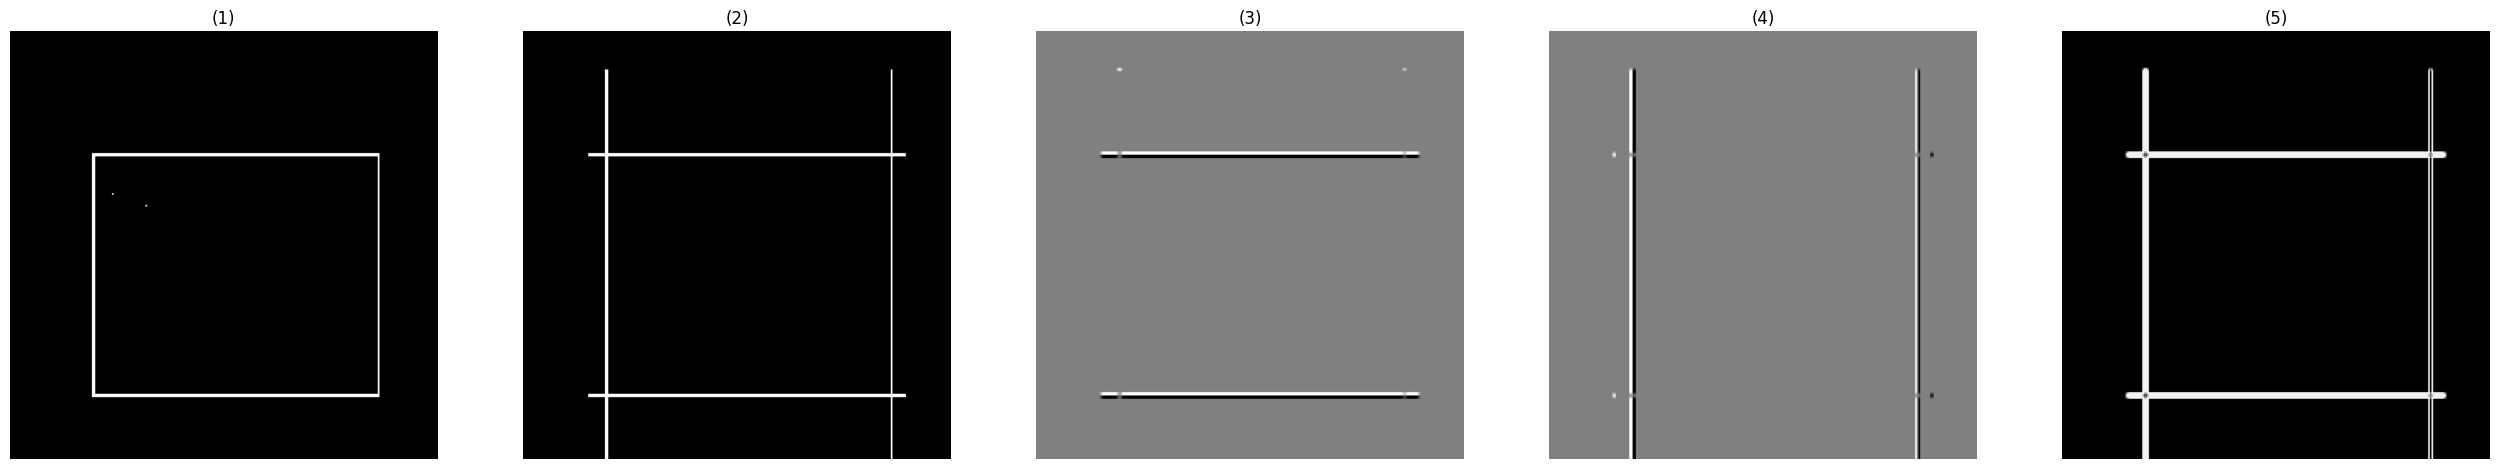

In [8]:
#sobel:
cow_sobel_x = sobel_h(morp_cow)  # Sobel operator for horizontal edges
cow_sobel_y = sobel_v(morp_cow)  # Sobel operator for vertical edges

# Combine the horizontal and vertical edges to get the magnitude
cow_sobel_magnitude = np.sqrt(cow_sobel_x**2 + cow_sobel_y**2)

show_images(images=[result_cow,morp_cow, cow_sobel_x, cow_sobel_y, cow_sobel_magnitude])

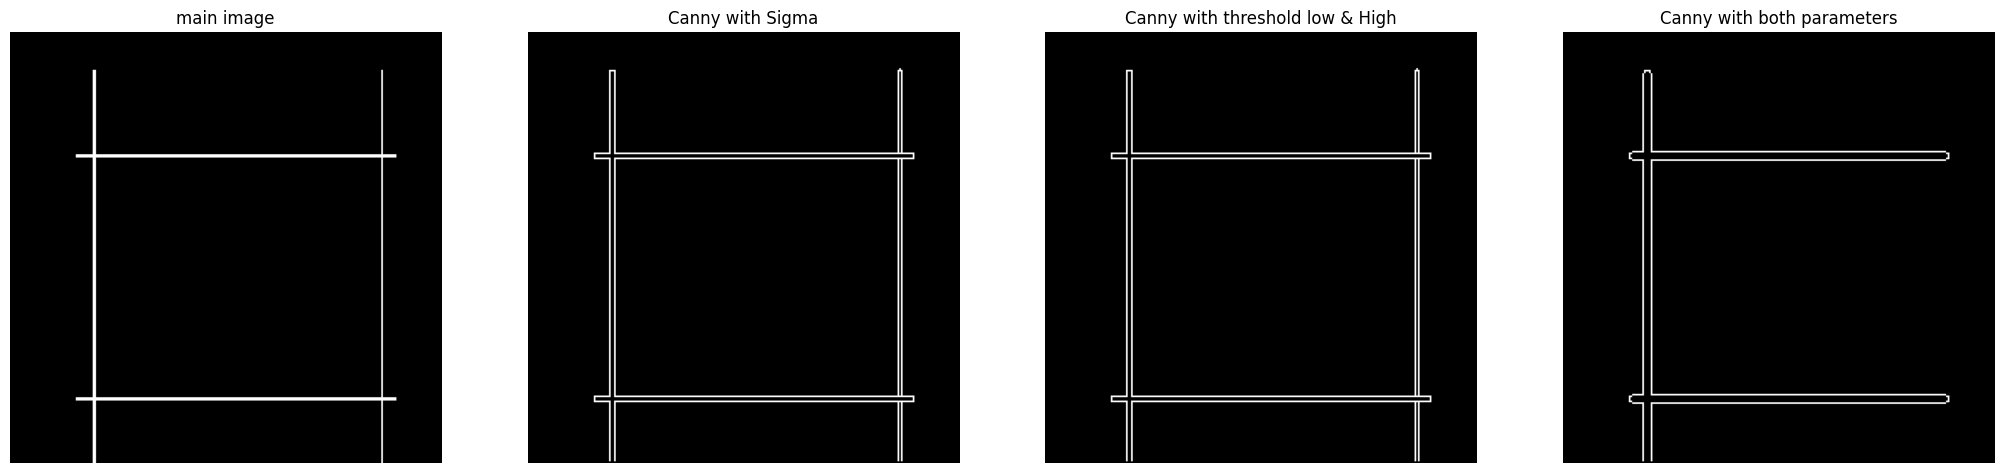

In [9]:
# Edge Detection

cow_canny_img_sigma=canny(morp_cow, sigma=1)  # increasing sigma detects stronger edges
cow_canny_with_both_threshold=canny(morp_cow, high_threshold=0.8, low_threshold=0.5)
cow_canny_with_both_par=canny(morp_cow, sigma=2, high_threshold=0.8, low_threshold=0.5)


show_images(images=[morp_cow,cow_canny_img_sigma ,cow_canny_with_both_threshold, cow_canny_with_both_par], titles=["main image","Canny with Sigma","Canny with threshold low & High", "Canny with both parameters"])


Step4: Hough Transform

https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

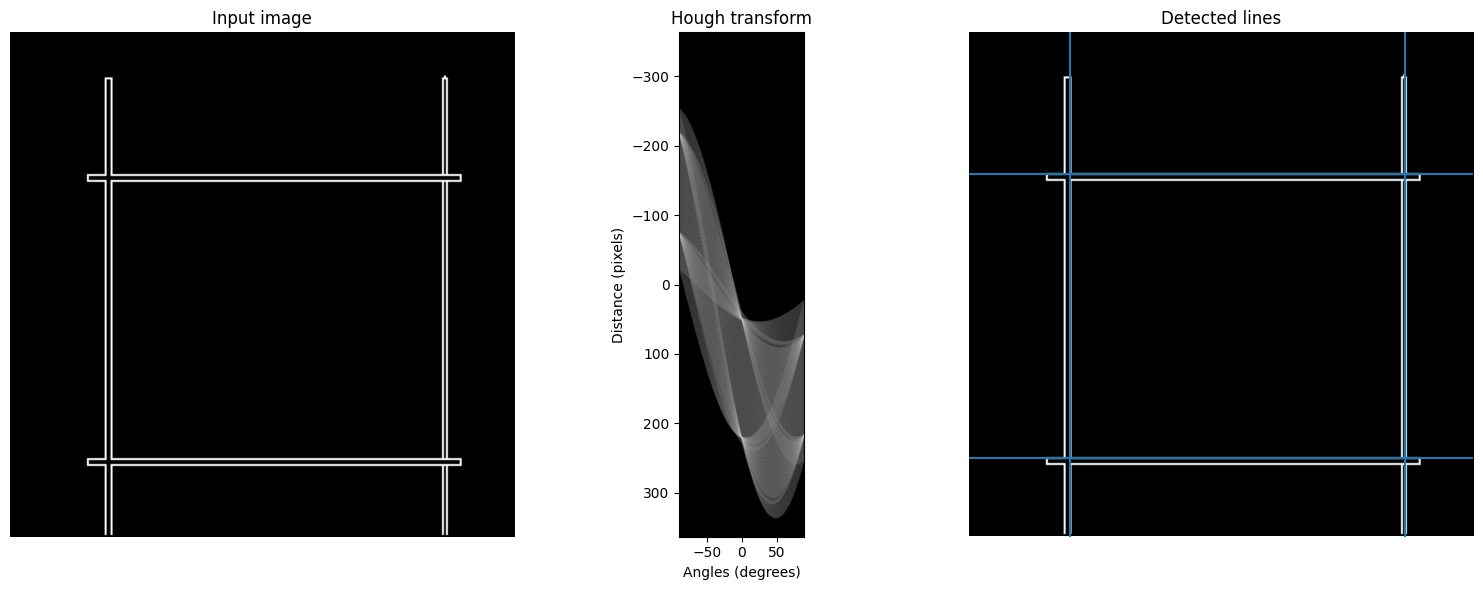

[(221.0, 72.0), (221.0, 216.0), (51.0, 72.0), (51.0, 216.0)]


In [10]:
#Given points (xi ,yi) find (R,θ)
'''
1. Parameter space is divided into accumulator cells A, all, initially, set to zero. 
2. For every point p(x,y) in image, change m in the range and calculate c. 
        C= - xm + y
3. A(m, c) = A(m, c) + 1 

At the end the value of A(mi , cj ) corresponds to the number of points that lie on the line: y = - mi x + cj

'''
image=cow_canny_img_sigma

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
h, theta, d = hough_line(image, theta=tested_angles)


# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()
ax[0].imshow(image, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()


angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]


ax[1].imshow(np.log(1 + h), extent=bounds, cmap=cm.gray, aspect=1 / 1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image, cmap=cm.gray)
ax[2].set_ylim((image.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')



# Find intersection points
intersection_points = []


# the vertical lines will have a theta of around 0 or around 180; the horizontal lines will have a theta of around 90.
# Filter lines based on orientation
vertical_lines = []
horizontal_lines = []


for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    #lines.append((x0, y0))
    if np.degrees(angle) % 180 == 0:  # Check if the line is approximately vertical
        vertical_lines.append((x0, y0))
    elif np.degrees(angle) % 90 == 0:  # Check if the line is approximately horizontal
        horizontal_lines.append((x0, y0))

    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))


# Find intersection points between vertical and horizontal lines
for v_line in vertical_lines:
    for h_line in horizontal_lines:
        intersection_points.append((v_line[0], h_line[1]))



# print(points) :  [(68.0, 0.0), (156.0, 0.0), (-1.2491397351303002e-14, 204.0), (-4.7148901767173095e-15, 77.0)]

plt.tight_layout()
plt.show()


print(intersection_points)


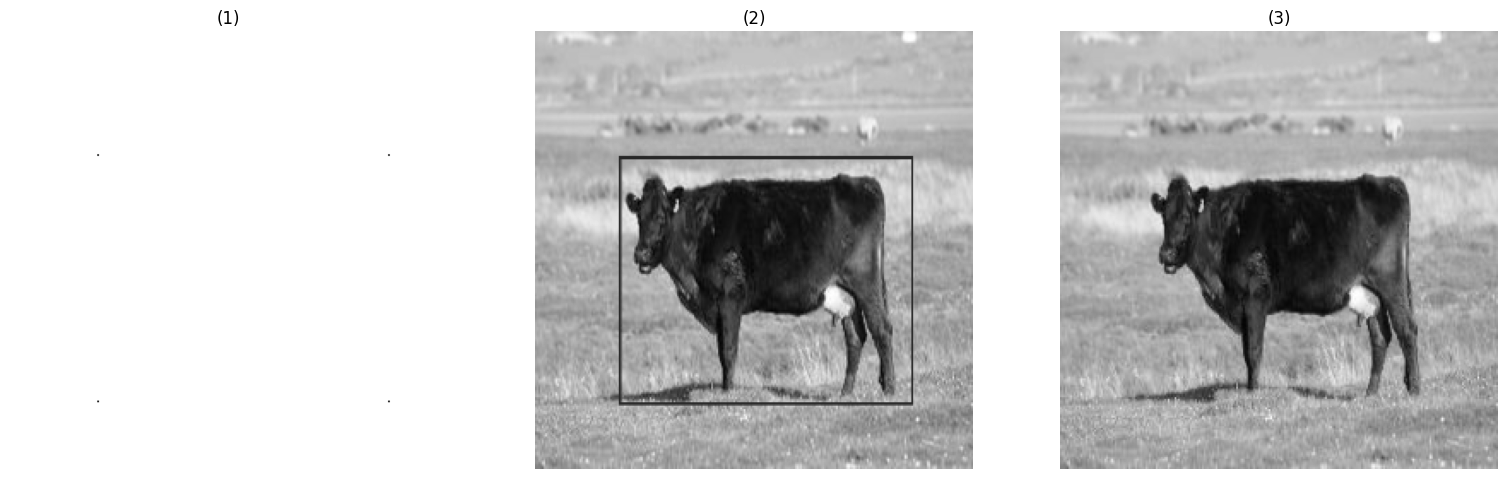

In [11]:
test_size = (256, 256)
test = np.ones((test_size))


# Coordinates of four white dots
coordinates = [(221.0, 72.0), (221.0, 216.0), (51.0, 72.0), (51.0, 216.0)]

# Convert coordinates to integers
coordinates = [(int(x), int(y)) for x, y in coordinates]

# Set the values at the coordinates to 1 (white)
for x, y in coordinates:
    test[y, x] = 0  # Note: y comes first in indexing for images
    #cow_resized_orig[y,x]=(255,0,0)


#[(221, 72), (221, 216), (51, 72), (51, 216)]


show_images(images=[test, gray_sel_cow, gray_orig_cow])



# Step 6: subimage

51
221
72
216


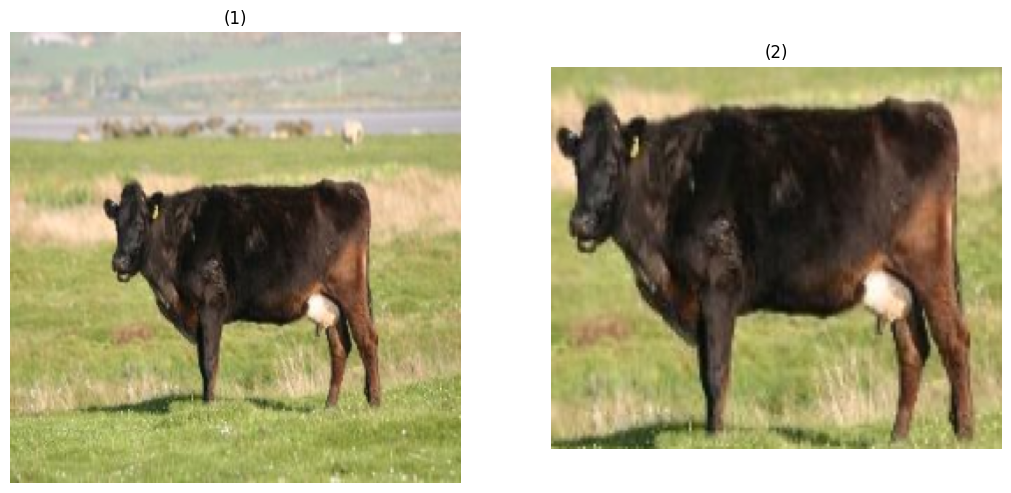

[[[169 175 105]
  [170 175 106]
  [171 176 107]
  ...
  [176 175 117]
  [176 174 117]
  [169 167 109]]

 [[166 172 100]
  [166 173 100]
  [169 175 102]
  ...
  [187 186 125]
  [185 183 124]
  [174 172 112]]

 [[164 171  96]
  [165 172  96]
  [168 175  99]
  ...
  [199 198 134]
  [196 194 132]
  [181 180 117]]

 ...

 [[135 143  85]
  [ 91 100  44]
  [ 99 108  54]
  ...
  [191 193 120]
  [183 185 111]
  [176 178 103]]

 [[ 95 103  40]
  [ 85  95  34]
  [ 85  94  34]
  ...
  [197 199 124]
  [190 192 117]
  [183 185 110]]

 [[163 173 105]
  [143 154  86]
  [134 145  78]
  ...
  [192 195 118]
  [192 193 118]
  [183 186 110]]]


In [18]:
our_img=cow_resized_orig
#print(coordinates) #[(221, 72), (221, 216), (51, 72), (51, 216)]

top_left , top_right, bottom_left, bottom_right= coordinates
y1=bottom_left[1]  #72
y2=bottom_right[1] #216
x1=bottom_right[0] #51
x2=top_right[0]  #221
print(x1)
print(x2)
print(y1)
print(y2)

subimage = our_img[ y1:y2 , x1:x2]

show_images(images=[our_img, subimage])
print(subimage[:,:,:])

# First approach: Mean shift - Color based segmentation

In [13]:


# def euclidean_distance(x, y):
#     return np.sqrt(np.sum((x - y)**2))

# def mean_shift(img, kernel_bandwidth=25, num_iterations=5):
#     height, width, _ = img.shape

#     # Flatten the image for easier computation
#     flat_img = img.reshape(-1, 3)

#     for _ in range(num_iterations):
#         for i in range(len(flat_img)):
#             x_i = flat_img[i]

#             # Compute the mean shift vector
#             mean_shift_vec = np.zeros_like(x_i, dtype=float)
#             weight_sum = 0

#             for j in range(len(flat_img)):
#                 x_j = flat_img[j]
#                 distance = euclidean_distance(x_i, x_j)
#                 weight = np.exp(-0.5 * (distance / kernel_bandwidth)**2)

#                 mean_shift_vec += weight * x_j
#                 weight_sum += weight

#             mean_shift_vec /= weight_sum

#             # Convert mean shift vector to uint8 before updating
#             flat_img[i] = mean_shift_vec.astype(np.uint8)

#     # Reshape the flattened image to the original shape
#     result_img = flat_img.reshape((height, width, 3)).astype(np.uint8)

#     return result_img



# # Apply Mean Shift algorithm
# result = mean_shift(our_img, kernel_bandwidth=30, num_iterations=5)




# Second approach: Region growing

Algo:
<br>
(1) Selection of a seed s, ie, an initial pixel. This step can be done:
<br>
    - Interactively (the user chooses the seed) or
    <br>
    - Automatically: the seed is randomly selected
<br>
(2) Choose a similarity criterion between two pixels
<br>
(3) Aggregate to s its neighboring similar pixels, resulting in a first region R1
<br>
(4) Choose a similarity criterion between a pixel and a region
<br>
(5) Aggregate to R1 its neighboring (ie, belonging to its external boundary) similar pixels, resulting in a region R2>R1
<br>
(6) Carry on the process until no more pixels can be aggregated
<br>

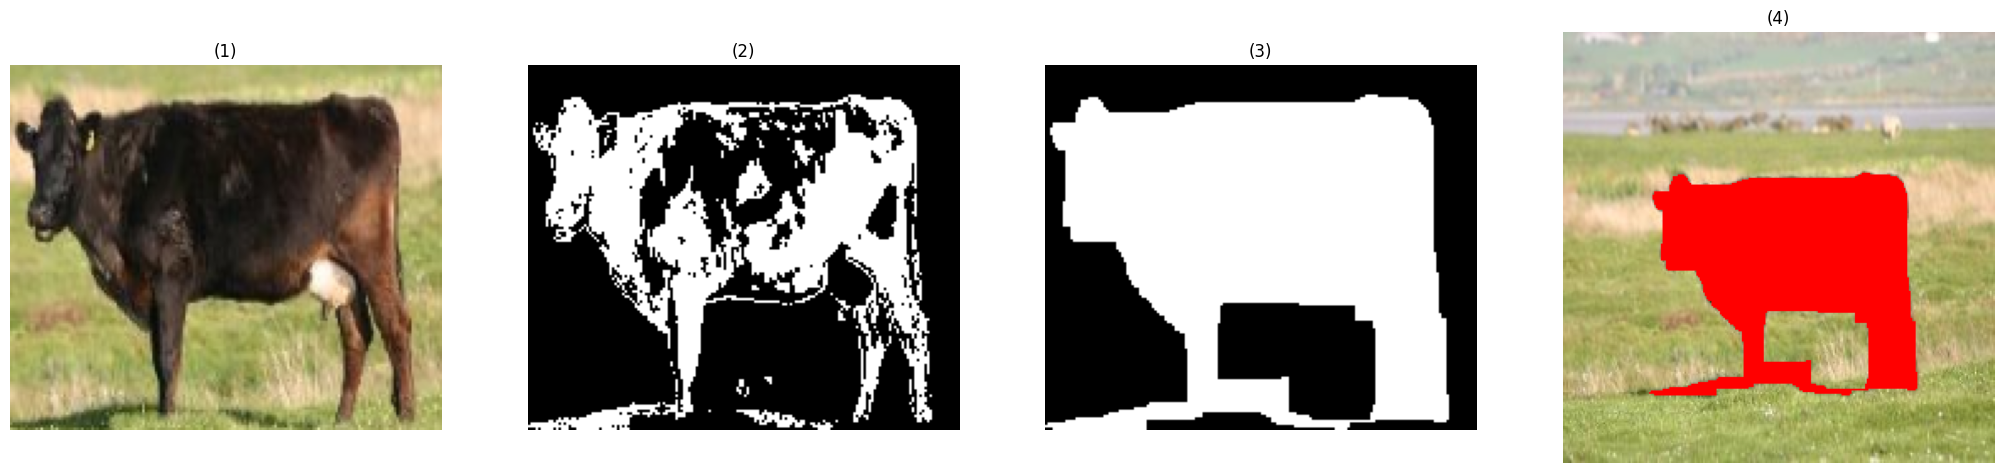

In [151]:
# Get the dimensions of the image
height, width, channels = subimage.shape

# consider it the middle pixel for now:  "will be given by user later"
# Calculate the middle pixel coordinates
middle_pixel_x = width // 2
middle_pixel_y = height // 2
# Get the RGB values of the middle pixel
middle_pixel_rgb = subimage[middle_pixel_y, middle_pixel_x]

# seed point 
seed= (middle_pixel_x,middle_pixel_y)
# seed color:
seed_color= middle_pixel_rgb


# extra_seed1= (middle_pixel_x - 10, middle_pixel_y + 10)
# extra_seed1_color= subimage[extra_seed1[1], extra_seed1[0]]

# extra_seed2= (middle_pixel_x + 10, middle_pixel_y - 10)
# extra_seed2_color= subimage[extra_seed2[1], extra_seed2[0]]

# extra_seed3= (middle_pixel_x + 10, middle_pixel_y + 10)
# extra_seed3_color= subimage[extra_seed3[1], extra_seed3[0]]



# paper: https://link.springer.com/referenceworkentry/10.1007/978-0-387-31439-6_450#:~:text=The%20similarity%20measure%20s(x,space%20(or%20color%20model). 
# similarity criteria based on the color:   "assuming working in RGB space"
def similarity_criterion(pixel_color, seed_color):
    # Calculate the color intensity difference between the pixel and the seed point
    #print(pixel_color,seed_color)

    #Euclidean dist:
    color_difference = np.linalg.norm(pixel_color - seed_color)
   # print(color_difference)

    # Check if the color difference is within the acceptable range
    if color_difference <= 150:
        #print("true")
        return True
    else:
        #print("false")
        return False
    
    

# Initialize the region   --- Region Growing part
region = np.zeros(subimage.shape)
region[seed[1], seed[0]] = 1
# region[extra_seed1[1], extra_seed1[0]] = 1
# region[extra_seed2[1], extra_seed2[0]] = 1
# region[extra_seed3[1], extra_seed3[0]] = 1

# Iteratively grow the region
for i in range(subimage.shape[0]):
    for j in range(subimage.shape[1]):
        pixel = subimage[i, j]
        if similarity_criterion(pixel, middle_pixel_rgb):
            region[i, j] = 1
        
        # elif similarity_criterion(pixel, extra_seed1_color):
        #     region[i, j] = 1
        # elif similarity_criterion(pixel, extra_seed2_color):
        #     region[i, j] = 1
        # elif similarity_criterion(pixel, extra_seed3_color):
        #     region[i, j] = 1


# apply morphology for the region:
se_reg = np.ones((20, 20), np.uint8)
gray_region= rgb2gray(region)
morh_reg= closing(gray_region,se_reg)
morh_reg= closing(morh_reg,se_reg)
morh_reg= closing(morh_reg,se_reg)



# Create a copy of the original image
result_image = our_img.copy()

# Update the pixels in the copy based on the region mask
result_image[y1:y2, x1:x2][morh_reg > 0] = [255, 0, 0]  # Set pixels in the region to red

show_images(images=[subimage, gray_region, morh_reg, result_image])
# show_images(images=[subimage, gray_region, morh_reg])

In [ ]:
# # Get the dimensions of the image
# height, width, channels = subimage.shape

# # Calculate the middle pixel coordinates
# middle_pixel_x = width // 2
# middle_pixel_y = height // 2

# # Get the RGB values of the middle pixel
# middle_pixel_rgb = subimage[middle_pixel_y, middle_pixel_x]

# print(f"RGB values of the middle pixel: {middle_pixel_rgb}")


# color = middle_pixel_rgb  # RGB values
# color_normalized = [x / 255.0 for x in color]  # Normalize to range [0, 1]

# plt.imshow([[color_normalized]])
# plt.axis('off')
# plt.show()

# seed= (middle_pixel_x, middle_pixel_y)

# # Define the growing criterion
# def similarity_criterion(pixel, seed_color):
#     # Calculate the color intensity difference between the pixel and the seed point
#     print(pixel,seed_color)
#     # assuming working in RGB space
#     #color difference = sqrt(pow(R1 - R2, 2) + pow(G1 - G2, 2) + pow(B1 - B2, 2))
#     color_difference = np.sqrt(np.power(pixel[0] - seed_color[0], 2) + np.power(pixel[1] - seed_color[1], 2) + np.power(pixel[2] - seed_color[2], 2))  

#     #normalized color difference = (color difference / 255) * 100
#     # dividing by max color difference (255) in RGB space
#     #This will give you a normalized color difference value between 0 and 100, where 0 means the colors are identical, and 100 means they are completely different.
#     normalized_color_difference = (color_difference / 255) * 100

#     #color similarity = 1 - (normalized color difference / 100)  
#     # This will give you a color similarity value between 0 and 1, where 0 means the colors are identical, and 1 means they are completely different.
#     # color_similarity = 1 - (normalized_color_difference / 100)

#     # color sim=0 "identical" if normalized diff <30 else 1 "diff"
#     if normalized_color_difference <30:
#         return 0
#     else:
#         return 1


# # Initialize the region
# region = np.zeros(subimage.shape[:2], dtype=np.uint8)
# region[seed[0], seed[1]] = 1

# # Iteratively grow the region
# for i in range(subimage.shape[0]):
#     for j in range(subimage.shape[1]):
#         pixel = subimage[i, j]
#         if similarity_criterion(pixel, middle_pixel_rgb):
#             region[i, j] = 1

# # Find the connected components in the region
# labels, num_labels = np.unique(region, return_counts=True)

# # Print the labels
# print(labels)





In [ ]:


# # Get the dimensions of the image
# height, width, channels = subimage.shape

# # Calculate the middle pixel coordinates
# middle_pixel_x = width // 2
# middle_pixel_y = height // 2

# # Get the RGB values of the middle pixel
# middle_pixel_rgb = subimage[middle_pixel_y, middle_pixel_x]

# print(f"RGB values of the middle pixel: {middle_pixel_rgb}")

# # Define the growing criterion
# def similarity_criterion(pixel, seed_color):
#     # Calculate the color intensity difference between the pixel and the seed point
#     color_difference = np.sqrt(np.power(pixel[0] - seed_color[0], 2) + np.power(pixel[1] - seed_color[1], 2) + np.power(pixel[2] - seed_color[2], 2))

#     # Normalize the color difference by dividing by the maximum possible color difference (255) in RGB space
#     normalized_color_difference = (color_difference / 255) * 100

#     # Check if the colors are similar
#     if normalized_color_difference < 30:
#         return 0
#     else:
#         return 1

# # Initialize the region
# region = np.zeros(subimage.shape[:2], dtype=np.uint8)
# region[seed[0], seed[1]] = 1

# # Iteratively grow the region
# for i in range(subimage.shape[0]):
#     for j in range(subimage.shape[1]):
#         pixel = subimage[i, j]
#         if similarity_criterion(pixel, middle_pixel_rgb):
#             region[i, j] = 1

# # Find the connected components in the region
# # labels, num_labels = np.connected_components(region)

# # # Print the labels
# # print(labels)

# # Visualize the segmented image with regions
# plt.imshow(region, cmap='gray')
# plt.axis('off')
# plt.show()

In [ ]:

# #border tracing:
# #1. Search image from top left till a starting pixel Po of new region border is found
# # 2. Define dir which stores the direction of the move from the previous to the 
# # current border element. 
# # 3. Search the 3x3 neighborhood of current pixel in anti-clockwise direction 
# # beginning at (dir+3) mod 4
# # 4. If the current boundary element Pn is equal to the second border element P1
# # and if the previous border element Pn-1 is equal to P0 stop. Otherwise go to 
# # step 3
# # 5. The detected inner border is represented by P0 ... Pn-2



# # https://users.utcluj.ro/~igiosan/Resources/PI/L6/PI-L6e.pdf 

# height, width, _ = region.shape

# # Finding P0
# Po = None
# for i in range(height):
#     for j in range(width):
#         if gray_region[i, j] == 1:
#             Po = (i, j)
#             break
#     if Po:
#         break
# print(Po)

# # Check if starting pixel is found
# if Po:
#     # Define directions (up, right, down, left)
#     # 3: down , 1: up , 0: left , 2: right
#     directions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
#     # dir= {'up':(),'down': (), 'left': (), 'right': ()}

#     # Initialize variables
#     P0 = Po
#     Pn = None
#     P1 = None
#     border_list = []  # to trace the border
#     border_list.append(P0)

#     # Initialize direction
#     dir_index = 0  

#     # Start border tracing
#     while True:
#         # Search 3x3 neighborhood in anti-clockwise direction
#         for k in range(3):
#             dir_index = (dir_index + 3) % 4
#             next_pixel = (P0[0] + directions[dir_index][0], P0[1] + directions[dir_index][1])
#             print(dir_index, next_pixel)

#             # Check if the next pixel is within the image boundaries
#             if 0 <= next_pixel[0] < height and 0 <= next_pixel[1] < width:
#                 print(gray_region[next_pixel])
#                 if gray_region[next_pixel] == 1:
#                     Pn = next_pixel
#                     if P1 is None:
#                         P1 = Pn
#                     break

#         # Check if the current boundary element Pn is equal to the second border element P1
#         # and if the previous border element Pn-1 is equal to P0
#         # if Pn == P1 and border_list and Pn == border_list[0]:
#         #     break
#         if Pn == P1 and P0 == border_list[0]:
#             break

#         # Add the current boundary element to the list
#         border_list.append(Pn)

#         # Update the starting pixel and direction
#         P0 = Pn

#     # Convert the list of boundary pixels to a NumPy array
#     border_pixels = np.array(border_list)
#     print(border_pixels)
    

#     # Create an empty mask
#     border_mask = np.zeros_like(gray_region, dtype=np.uint8)

#     # Draw the border on the mask
#     cv2.polylines(border_mask, [border_pixels], isClosed=False, color=1, thickness=1)

#     # Display the original image and the detected inner border
#     show_images(images=[subimage, border_mask])
# else:
#     print("Starting pixel not found.")

